# 업리프트 분석

## 1. 데이터 이해 및 EDA

- Criteo Uplift Prediction Dataset의 구조와 분포, 처리군·대조군 비율, 주요 변수(ex- 전환·방문)의 기초 통계를 파악

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='AppleGothic')
sns.set(font='AppleGothic')

df = pd.read_csv("hf://datasets/criteo/criteo-uplift/criteo-research-uplift-v2.1.csv.gz")

In [29]:
df

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979587,26.297764,10.059654,9.006250,4.679882,10.280525,4.115453,-3.282109,4.833815,3.839578,13.190056,5.300375,-0.168679,1,0,0,0
13979588,12.642207,10.679513,8.214383,-1.700105,10.280525,3.013064,-13.955150,6.269026,3.971858,13.190056,5.300375,-0.168679,1,0,0,1
13979589,12.976557,10.059654,8.381868,0.842442,11.029584,4.115453,-8.281971,4.833815,3.779212,23.570168,6.169187,-0.168679,1,0,1,0
13979590,24.805064,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0


In [30]:
print(df.info())                 # 컬럼, 결측치, 자료형 확인
print(df.describe())             # 수치형 컬럼 요약 통계 확인

# 처리(treatment) 비율 확인
print("treatment 비율:\n", df['treatment'].value_counts(normalize=True))

# 그룹별 conversion & visit 평균 비교
grp = df.groupby('treatment')[['conversion','visit']].mean()
print("그룹별 전환/방문율:\n", grp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB
None
                 f0            f1            f2            f3            f4  \
count  1.397959e+07  1.397959e+07  1.397959e+07  1.397959e+07  1.397959e+07   
mean   1.962030e+01  1.006998e+01  8.446582e+00  4.178923e+00  1.033884e+01   
std    5.377464e+00  1.047557e-01  2.993161e-01  1.336645e+00  3.433081e-01   
min    1.261636e+01  1.005965e+01  8.214383e+00 -8.398387e+00  

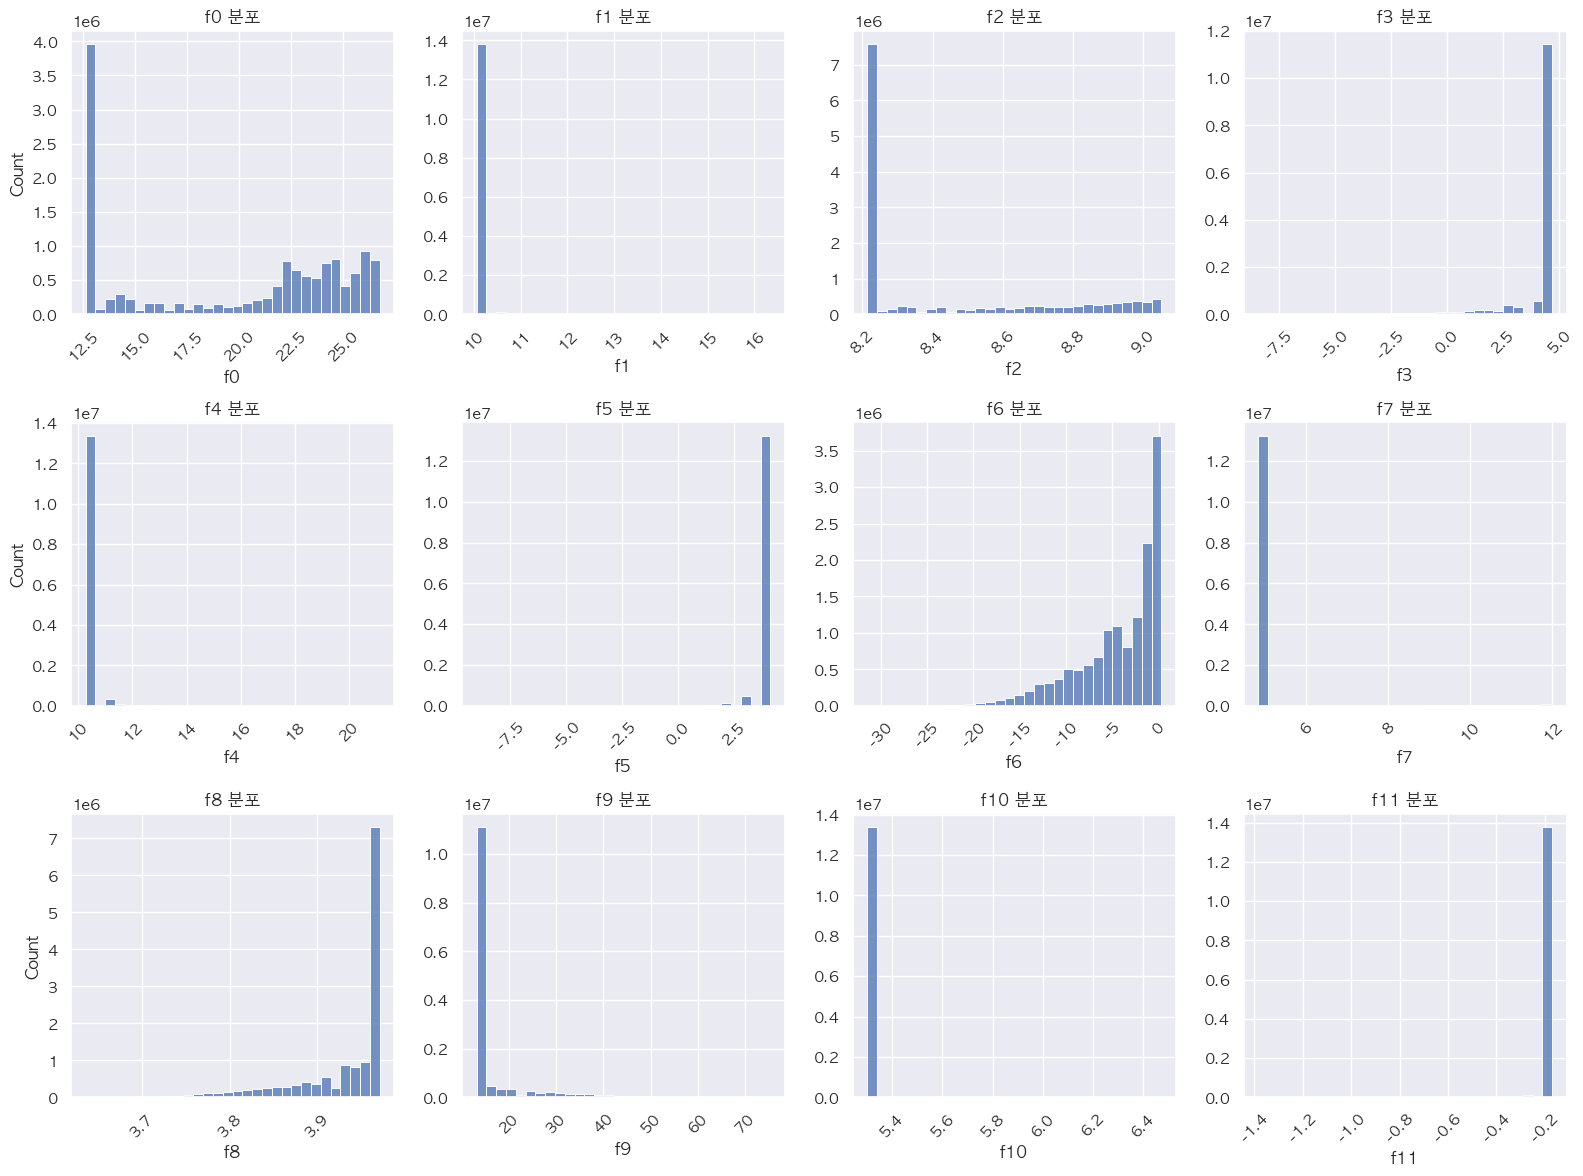

In [31]:
# f0~f11 히스토그램
fig, axes = plt.subplots(3, 4, figsize=(16,12))
for idx, ax in enumerate(axes.flatten()):
    sns.histplot(df[f"f{idx}"], bins=30, kde=False, ax=ax)
    ax.set_title(f"f{idx} 분포")
    ax.tick_params(axis='x', rotation=45)
    if idx % 4 != 0:                             
        ax.set_ylabel("")
plt.tight_layout()
plt.show()

- 데이터 규모: 약 14백만 건의 익명화된 광고 실험 데이터 (13,979,592개)

- 처치 비율: 실험군(treatment) 85% vs 대조군(control) 15%

- 결과 변수:
    - 구매 전환(conversion) 희소(0.3%)
    - 방문(visit) 상대적으로 자주(5%)

- 피처 분포: 대부분 f0~f11 변수는 한쪽으로 쏠린 분포를 보였고, 특히 몇몇(f1, f3, f5, f7, f11 등)은 거의 상수에 가까워 보임

## 2. 분석 목적 정의

- EDA 결과 상대적으로 방문(visit) 빈도가 높고 전환(conversion)은 희소하기 때문에, 사이트 방문률 uplift를 예측해 상위 k% 고객에게 광고 예산을 집중하여 추가 방문 수를 극대화하는 것을 목표
    - “광고가 실제로 방문을 얼마나 끌어올렸는지”를 확인

- 핵심 지표로는 Top‑k 타겟팅 시 얻는 추가 방문 수와 전체 Qini AUC를 사용할 예정

## 3. 피처 엔지니어링

- EDA에서 파악한 분포·희소성에 맞춰 주요 피처를 변환·추가

- 속도 확보를 위해 전체에서 20,000건만 추출(원본 비율 85:15 유지)

- 학습 시에는 이 20k 중 70%를, 평가 시에는 30%를 사용

- exposure → log1p(exposure) 변환
    - 극단치는 모델 학습 시 대부분의 값을 압도해 버려, 일반적인 노출 수준에 대한 패턴을 잘 못 잡게 되기에 변환

In [32]:
from sklearn.model_selection import train_test_split

# train_test_split 에서 train_size=20000, stratify로 treatment 비율 유지
df_sample, _ = train_test_split(
    df,
    train_size=20000,
    random_state=42,
    stratify=df['treatment']
)
df_sample = df_sample.reset_index(drop=True)

print("샘플 크기:", df_sample.shape)
print("샘플 treatment 비율:\n", df_sample['treatment'].value_counts(normalize=True))

샘플 크기: (20000, 16)
샘플 treatment 비율:
 treatment
1    0.85
0    0.15
Name: proportion, dtype: float64


In [33]:
import numpy as np

# 처리 그룹을 문자열로 매핑
df_sample['trt'] = df_sample['treatment'].map({0: 'control', 1: 'treatment'})

# exposure만 로그 변환하여 피처로 사용
df_sample['exp_log'] = np.log1p(df_sample['exposure'])

# 최종 입력 피처 목록: f0~f11 원본 + exp_log
base_feats = [f"f{i}" for i in range(12)]
x_cols = base_feats + ['exp_log']

print("사용할 피처 개수:", len(x_cols))
print("입력 피처 목록:", x_cols)

사용할 피처 개수: 13
입력 피처 목록: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'exp_log']


## 4. Uplift 모델 학습 및 예측

- 균형 있게 준비한 학습 데이터로 UpliftRandomForestClassifier를 학습시키고, 테스트 세트에 대해 uplift 점수를 예측

In [34]:
from sklearn.model_selection import train_test_split
from causalml.inference.tree import UpliftRandomForestClassifier

# 1) 입력·출력 배열 생성
X  = df_sample[x_cols].values             # f0~f11 + exp_log
tr = df_sample['trt'].values              # 'control' / 'treatment'
y  = df_sample['visit'].values            # 방문 여부(0/1)

# 2) 학습/테스트 분할 (70:30 비율, treatment 비율 유지)
X_train, X_test, tr_train, tr_test, y_train, y_test = train_test_split(
    X, tr, y,
    test_size=0.3,
    random_state=42,
    stratify=tr
)

# 3) 모델 초기화 & 학습
model = UpliftRandomForestClassifier(
    control_name='control',      # 'control' 그룹 레이블
    n_estimators=100,            # 트리 개수
    max_depth=7,                 # 최대 깊이
    min_samples_leaf=50,         # 단말 노드 최소 샘플 수
    min_samples_treatment=30,    # treatment 최소 샘플 수
    random_state=42
)
model.fit(X_train, tr_train, y_train)

# 4) uplift 점수 예측
uplift_score = model.predict(X_test)
print("예측된 uplift 점수 샘플:", uplift_score[:5])

예측된 uplift 점수 샘플: [[ 0.00956794]
 [ 0.00687253]
 [ 0.00018161]
 [ 0.0042428 ]
 [-0.00021098]]


- 해당 값들은 각 고객별로 광고를 했을 때 방문 확률이 얼마나 바뀔지를 예측한 uplift 점수
    - ex1) 0.00956794 → 이 고객은 광고를 받으면 방문 확률이 약 0.96%p 증가할 것으로 예상
    - ex2) –0.00021098 → 광고를 하면 오히려 방문이 0.02%p 정도 감소할 가능성

- 즉,양수인 고객은 “광고를 해야 방문이 늘어날” 후보
- 음수인 고객은 “광고를 안 하는 게 나을” 후보로 해석 가능

## 5. 성능 평가 및 사용자 세그멘테이션

- Manual Qini Curve를 계산·시각화하고, 상위/하위 20% uplift 사용자 그룹의 특징을 비교

In [37]:
# 1) uplift 점수 1D 배열로 변환 및 요약
uplift_flat = uplift_score.ravel()
print("Uplift score summary:")
print(f"  min: {uplift_flat.min():.4f}, 25th: {np.percentile(uplift_flat,25):.4f}, "
      f"median: {np.median(uplift_flat):.4f}, 75th: {np.percentile(uplift_flat,75):.4f}, max: {uplift_flat.max():.4f}\n")

Uplift score summary:
  min: -0.0875, 25th: -0.0008, median: 0.0003, 75th: 0.0048, max: 0.2321



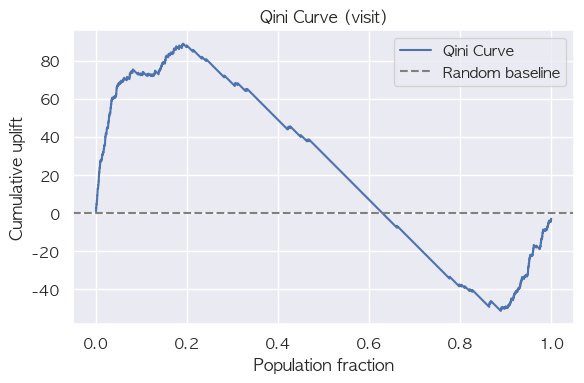

Qini AUC (전체 누적 추가 방문 면적): 23.01
최적 타겟 비율(k): 19.15% (추가 방문 수: 89.0건)


In [ ]:
# 2) Manual Qini Curve 계산
y_arr   = np.asarray(y_test).astype(int).ravel()
w_arr   = (np.asarray(tr_test)=='treatment').astype(int).ravel()
tau_arr = uplift_flat

# 2-1) 내림차순 정렬
order    = np.argsort(-tau_arr)
y_s      = y_arr[order]
w_s      = w_arr[order]

# 2-2) 누적 방문수 계산 (treatment 그룹만)
cum_conv    = np.cumsum(y_s * w_s)
baseline_rt = (y_arr * (1-w_arr)).sum() / (1-w_arr).sum()
cum_N       = np.arange(1, len(y_arr)+1)
rand_cum    = baseline_rt * cum_N

# 2-3) Qini 값, 표본 비율
qini_vals = cum_conv - rand_cum
frac       = cum_N / len(y_arr)

# 2-4) 시각화
plt.figure(figsize=(6,4))
plt.plot(frac, qini_vals, label='Qini Curve')
plt.axhline(0, color='gray', linestyle='--', label='Random baseline')
plt.title("Qini Curve (visit)")
plt.xlabel("Population fraction")
plt.ylabel("Cumulative uplift")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2-5) Qini AUC 및 최적 k 계산
qini_auc = np.trapz(qini_vals, x=frac)
opt_idx  = np.argmax(qini_vals)
opt_k    = frac[opt_idx]
opt_gain = qini_vals[opt_idx]

print(f"Qini AUC (전체 누적 추가 방문 면적): {qini_auc:.2f}")
print(f"최적 타겟 비율(k): {opt_k:.2%} (추가 방문 수: {opt_gain:.1f}건)")

In [39]:
# 3) 고객 세그멘테이션
df_test = pd.DataFrame(X_test, columns=x_cols)
df_test['uplift']  = uplift_flat
df_test['segment'] = 'Mid'

# 상위/하위 20% 정의
k       = 0.20
high_cut = np.quantile(uplift_flat, 1-k)
low_cut  = np.quantile(uplift_flat, k)

df_test.loc[df_test['uplift'] >= high_cut, 'segment'] = 'High'
df_test.loc[df_test['uplift'] <= low_cut,  'segment'] = 'Low'

# 3-1) 각 세그먼트별 피처 평균
mean_by_seg = df_test.groupby('segment')[x_cols].mean()
print("Segment별 피처 평균:\n", mean_by_seg, "\n")

# 3-2) High vs Low 차이 Top-5
diff = (mean_by_seg.loc['High'] - mean_by_seg.loc['Low']).abs().sort_values(ascending=False)
top5 = diff.index[:5].tolist()
print("High vs Low 구분 Top‑5 피처:", top5, "\n")

Segment별 피처 평균:
                 f0         f1        f2        f3         f4        f5  \
segment                                                                  
High     18.402089  10.117358  8.535473  2.570912  10.476905  3.737175   
Low      19.457844  10.059654  8.386464  4.591827  10.370275  4.073875   
Mid      20.083235  10.059654  8.441265  4.615931  10.288365  4.112391   

               f6        f7        f8         f9       f10       f11   exp_log  
segment                                                                         
High    -7.659641  5.986115  3.887785  20.131119  5.404633 -0.175775  0.072203  
Low     -5.453408  5.051926  3.919060  18.311728  5.342620 -0.173666  0.016751  
Mid     -2.316984  4.850896  3.953265  13.916157  5.307661 -0.168781  0.003466   

High vs Low 구분 Top‑5 피처: ['f6', 'f3', 'f9', 'f0', 'f7'] 



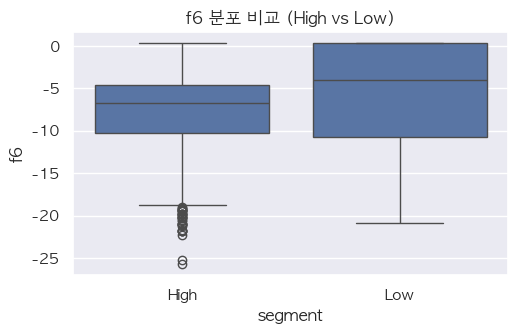

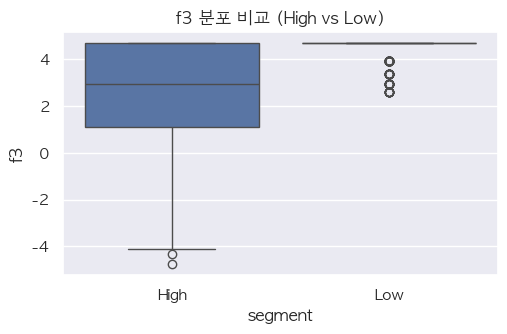

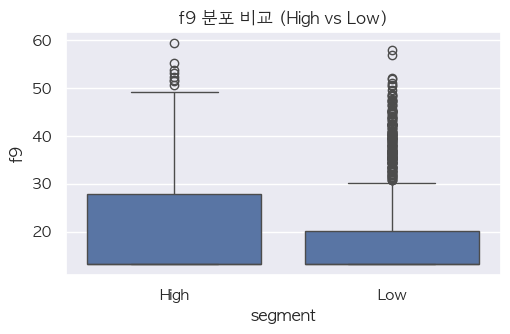

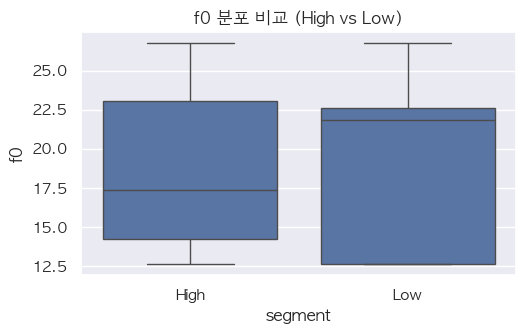

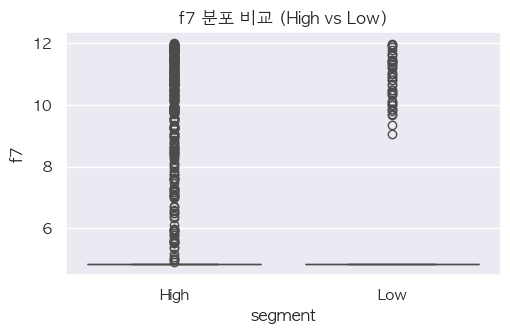

In [40]:
# 4) 주요 피처 boxplot 시각화 (High vs Low)
for feat in top5:
    plt.figure(figsize=(5,3))
    sns.boxplot(x='segment', y=feat, data=df_test[df_test['segment'].isin(['High','Low'])])
    plt.title(f"{feat} 분포 비교 (High vs Low)")
    plt.show()

## 6. 분석 결과 정리

- **Qini AUC**: 23.01  
  - uplift 모델이 **랜덤 대비 훨씬 우수함을 보여주는 면적 기반 지표**  
  - 단위가 없는 면적 값으로, 모델 성능 비교에 활용

- **최적 타겟 비율 (k)**: 19.15%  
  - 상위 **19.15%** 고객에게만 광고를 집행했을 때 **+89건**의 순수 추가 방문 기대할 수 있음

- **High vs Low 세그먼트 특징 (Top‑5 피처)**  
  1. **f6**: High 평균 –7.66 vs Low –5.45 → 값이 낮을수록 uplift가 큼  
  2. **f3**: High 2.57 vs Low 4.59 → 낮은 구간에서 효과가 높음  
  3. **f9**: High 20.13 vs Low 18.31 → 값이 높을수록 uplift가 큼  
  4. **f0**: High 18.40 vs Low 19.46 → 낮을수록 반응이 좋음  
  5. **f7**: High 5.99 vs Low 5.05 → 값이 높을수록 uplift가 큼  

- **실행 전략**  
  - 상위 **20%** 고객에게 광고 예산을 집중 집행  
  - 특히 `f6`이 낮고, `f9`·`f7`이 높으며, `f0`·`f3`이 낮은 사용자 우선 타겟  
  - 나머지 고객군에는 광고 집행 축소 또는 대체 캠페인(리마케팅 등) 검토  